In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [3]:
# Data starts in filecoin_daily_stats 2020-08-24
# genesis block was in 2020-08-24 23:00:00 

# Today is 2022-06-01
current_date = datetime.date(2022, 5, 31) 
current_day = (current_date - datetime.date(2020, 8, 25)).days

start_date = datetime.date(2021, 1, 1) 
start_day = (start_date - datetime.date(2020, 8, 25)).days

# Forecast is one year ahead from today
forecast_lenght = 365
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-01-01
2022-05-31
2023-05-31


In [4]:
renewal_rate= 0.5
rb_onboard_power = 27.0
fil_plus_rate = 0.029

duration = 360

## 2. Input data

#### Sector scheduled expirations

In [5]:
res = get_sector_expiration_stats(start_date,current_date,end_date,fil_plus_rate)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil                302307682.06646
mined_fil                     189864925.228997
vested_fil                    259145066.384969
locked_fil                    133023519.246253
burnt_fil                      30745409.263027
date                                2022-05-31
total_raw_power_eib                  16.322449
total_qa_power_eib                   17.064621
day_onboarded_rb_power_pib           27.261078
day_onboarded_qa_power_pib           33.469294
day_renewed_qa_power_pib                   0.0
Name: 514, dtype: object

In [7]:
fil_stats_df.head()

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,6.330064e+07,2.165377e+07,6.208498e+07,2.734325e+07,1.016148e+07,2021-01-02,1.692054,1.692169,18.329468,18.026659,0.0
1,6.376363e+07,2.189504e+07,6.273312e+07,2.757715e+07,1.035400e+07,2021-01-03,1.709267,1.709389,17.258636,16.930398,0.0
2,6.427617e+07,2.213790e+07,6.338126e+07,2.781334e+07,1.049628e+07,2021-01-04,1.723609,1.723745,17.520996,17.249958,0.0
3,6.478263e+07,2.238427e+07,6.402940e+07,2.805133e+07,1.064633e+07,2021-01-05,1.740771,1.740925,17.439056,17.196741,0.0
4,6.525545e+07,2.263025e+07,6.467754e+07,2.828820e+07,1.083076e+07,2021-01-06,1.754609,1.754779,17.367828,16.998434,0.0


## 2. Forecast power stats

In [8]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [9]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

print(len(power_df))
power_df.head()

880


,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-01-01,1.692054,1.692169,18.026659,0.0
1,2021-01-02,1.692054,1.692169,18.026659,0.0
2,2021-01-03,1.709267,1.709389,16.930398,0.0
3,2021-01-04,1.723609,1.723745,17.249958,0.0
4,2021-01-05,1.740771,1.740925,17.196741,0.0


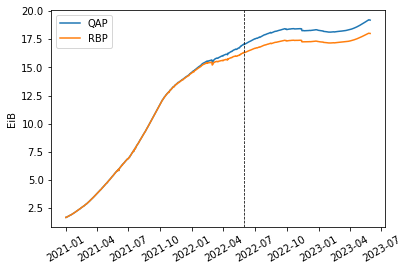

In [10]:
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("EiB")
plt.legend()
plt.show()

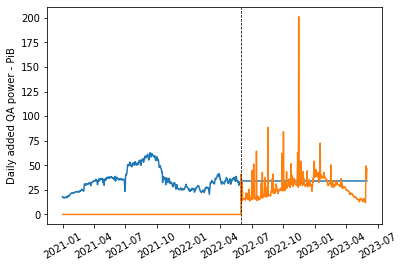

In [11]:
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("Daily added QA power - PiB")
plt.show()

## 3. Forecast Vesting

In [12]:
vest_df = compute_vesting_trajectory_df(start_day, end_day)

print(len(vest_df))
vest_df.head()

880


,days,total_vest
0,129,6.000005e+07
1,130,6.062496e+07
2,131,6.124988e+07
3,132,6.187479e+07
4,133,6.249970e+07


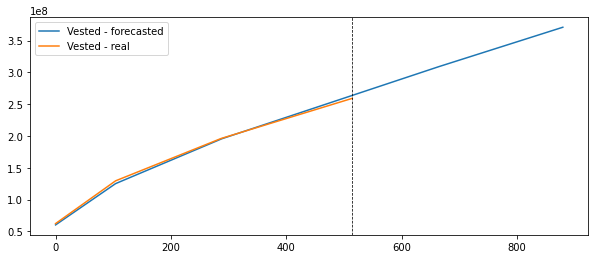

In [13]:
plt.figure(figsize=(10,4))
plt.plot(vest_df['total_vest'].values, label="Vested - forecasted")
plt.plot(fil_stats_df['vested_fil'].values,label="Vested - real")
plt.axvline(current_day-start_day-1, color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 4. Forecast minting stats and baseline

In [14]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_day,
    end_day,
    0,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

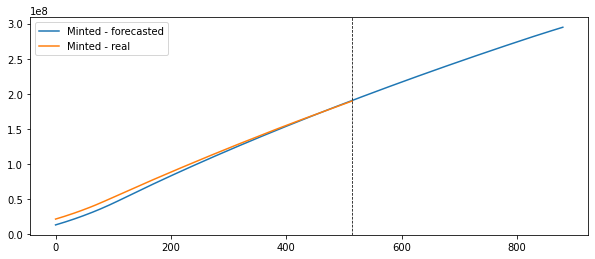

In [15]:
plt.figure(figsize=(10,4))
plt.plot(mint_df['cum_network_reward'].values, label="Minted - forecasted")
plt.plot(fil_stats_df['mined_fil'].values,label="Minted - real")
plt.axvline(current_day-start_day-1, color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 5. Compute circulating supply

In [16]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_day,
    end_day,
    current_day,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)

cil_df["date"] = pd.to_datetime(pd.date_range(start=start_date, end=end_date, freq="d"))[:-1]

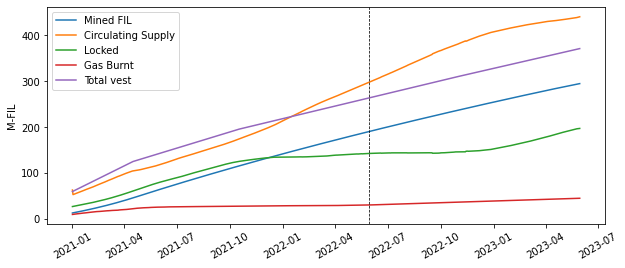

In [17]:
MEGA = 1_000_000

plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

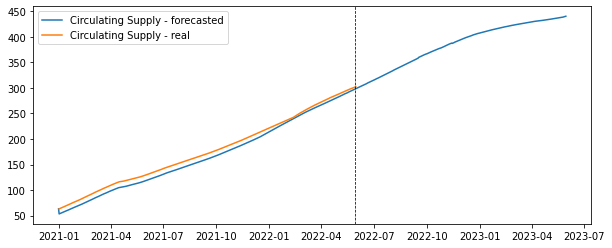

In [18]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

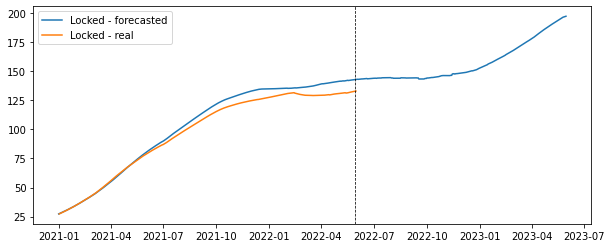

In [19]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()